In [12]:
import pandas as pd


late_shipments = pd.read_feather('late_shipments.feather')

In [14]:
late_shipments.head()

,id,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,late_delivery,late,product_group,sub_classification,...,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,freight_cost_groups,line_item_insurance_usd
0,36203.0,Nigeria,PMO - US,Direct Drop,EXW,Air,1.0,Yes,HRDT,HIV test,...,2996.0,266644.00,89.00,0.89,"Alere Medical Co., Ltd.",Yes,1426.0,33279.83,expensive,373.83
1,30998.0,Botswana,PMO - US,Direct Drop,EXW,Air,0.0,No,HRDT,HIV test,...,25.0,800.00,32.00,1.60,"Trinity Biotech, Plc",Yes,10.0,559.89,reasonable,1.72
2,69871.0,Vietnam,PMO - US,Direct Drop,EXW,Air,0.0,No,ARV,Adult,...,22925.0,110040.00,4.80,0.08,Hetero Unit III Hyderabad IN,Yes,3723.0,19056.13,expensive,181.57
3,17648.0,South Africa,PMO - US,Direct Drop,DDP,Ocean,0.0,No,ARV,Adult,...,152535.0,361507.95,2.37,0.04,"Aurobindo Unit III, India",Yes,7698.0,11372.23,expensive,779.41
4,5647.0,Uganda,PMO - US,Direct Drop,EXW,Air,0.0,No,HRDT,HIV test - Ancillary,...,850.0,8.50,0.01,0.00,Inverness Japan,Yes,56.0,360.00,reasonable,0.01


# ANOVA

data exploration first

In [18]:
# find the avg pack price by shioments
late_shipments.groupby('shipment_mode')['pack_price'].mean()

shipment_mode
Air            39.712395
Air Charter     4.226667
Ocean           6.432273
Name: pack_price, dtype: float64

In [20]:
# Group late_shipments by shipment_mode and calculate the standard deviation pack_price for each group
late_shipments.groupby('shipment_mode')['pack_price'].std()

shipment_mode
Air            48.932861
Air Charter     0.992969
Ocean           5.303047
Name: pack_price, dtype: float64

<Axes: xlabel='pack_price', ylabel='shipment_mode'>

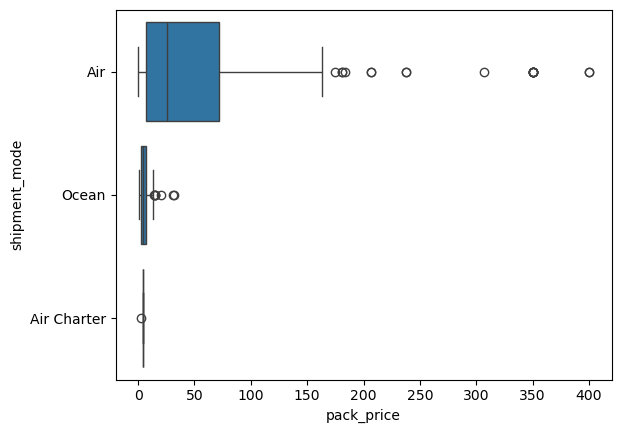

In [22]:
# Create a boxplot from late_shipments with "pack_price" as x and "shipment_mode" as y
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=late_shipments, x='pack_price', y='shipment_mode')


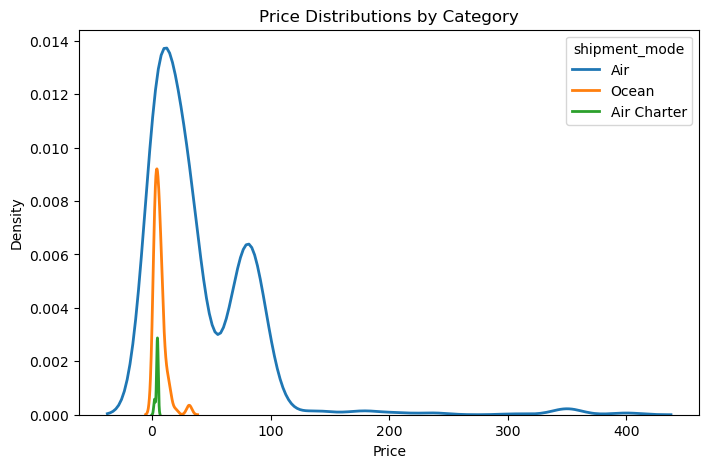

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
ax = sns.kdeplot(
    data=late_shipments,
    x='pack_price',
    hue='shipment_mode',
    fill=False,          # No fill, just the curves
    linewidth=2
)
plt.title('Price Distributions by Category')
plt.xlabel('Price')
plt.ylabel('Density')
# Get the legend and set the title
leg = ax.get_legend()
leg.set_title('shipment_mode')
plt.show()

There's def a difference- but is the differene between the distribution of pack prices for each of the 3 shipments statistically significant? 

The box plots made it look like the distribution of pack price was different for each of the three shipment modes. However, it didn't tell us whether the mean pack price was different in each category. To determine that, we can use an ANOVA test. 

In [26]:
# H0: Pack prices for every category of shipment mode are the same.

# HA: Pack prices for some categories of shipment mode are different
import pingouin

alpha = 0.1

# Run an ANOVA for pack_price across shipment_mode
anova_results = pingouin.anova(data=late_shipments, dv='pack_price', between='shipment_mode')

anova_results


,Source,ddof1,ddof2,F,p-unc,np2
0,shipment_mode,2,997,21.8646,5.089479e-10,0.042018


There is a significant difference in pack prices between the shipment modes. However, we don't know which shipment modes this applies to.

Enter Pairwise t-test...

In [29]:
pingouin.pairwise_tests(data=late_shipments, 
                        dv='pack_price', 
                        between='shipment_mode', 
                        padjust='bonf')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,shipment_mode,Air,Air Charter,False,True,21.179625,600.685682,two-sided,8.748346e-75,2.624504e-74,bonf,5.809e+76,0.726592
1,shipment_mode,Air,Ocean,False,True,19.335760,986.979785,two-sided,6.934555e-71,2.080367e-70,bonf,1.129e+67,0.711119
2,shipment_mode,Air Charter,Ocean,False,True,-3.170654,35.615026,two-sided,3.123012e-03,9.369037e-03,bonf,15.277,-0.423775


**Applying the Bonferroni adjustment shows the p-values (p-corr) for the t-tests between each of the three groups are all less than alpha (0.1), therefore we reject he null hypothesis that there is no difference between the groups**

**Summary:**

ANOVA is used as an initial test to detect any overall differences among group means.
Pairwise t-tests are used after ANOVA (if it is significant) to determine exactly which groups differ from each other.

# More proportion testing

**Instead of calulating a Z-score, couldn't you just compare a data point in question directly to the mean and standard deviation of the data set to get a sense of the outlierness?**

Yes, you can get a general idea of how a data point compares to the mean and standard deviation by simply looking at its value relative to those numbers. For example, if you know the mean is 50 and the standard deviation is 10, and your data point is 70, you can see that it’s 20 units above the mean, or “about two standard deviations” away.

However, the z score formalizes this comparison in a standardized way:

Direct comparison (just looking at the numbers) gives you a rough sense, but it’s not always easy to interpret, especially if you’re comparing across different datasets with different means and standard deviations.
Z score tells you exactly how many standard deviations away from the mean a value is, and puts everything on the same scale (mean = 0, standard deviation = 1). This makes it much easier to:
Compare values from different datasets or distributions
Identify outliers
Use statistical tables and probability calculations
Example:

Dataset A: mean = 50, std = 10, value = 70 → z = (70-50)/10 = 2

Dataset B: mean = 100, std = 20, value = 140 → z = (140-100)/20 = 2

Even though the raw values are very different, both have a z score of 2, meaning they are both 2 standard deviations above their respective means.

In summary:
While you can get a sense by looking at the mean and standard deviation, the z score gives you a precise, standardized way to interpret and compare data points, especially across different contexts.

# One-sample proportion tests

In [37]:
late_shipments.head()

,id,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,late_delivery,late,product_group,sub_classification,...,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,freight_cost_groups,line_item_insurance_usd
0,36203.0,Nigeria,PMO - US,Direct Drop,EXW,Air,1.0,Yes,HRDT,HIV test,...,2996.0,266644.00,89.00,0.89,"Alere Medical Co., Ltd.",Yes,1426.0,33279.83,expensive,373.83
1,30998.0,Botswana,PMO - US,Direct Drop,EXW,Air,0.0,No,HRDT,HIV test,...,25.0,800.00,32.00,1.60,"Trinity Biotech, Plc",Yes,10.0,559.89,reasonable,1.72
2,69871.0,Vietnam,PMO - US,Direct Drop,EXW,Air,0.0,No,ARV,Adult,...,22925.0,110040.00,4.80,0.08,Hetero Unit III Hyderabad IN,Yes,3723.0,19056.13,expensive,181.57
3,17648.0,South Africa,PMO - US,Direct Drop,DDP,Ocean,0.0,No,ARV,Adult,...,152535.0,361507.95,2.37,0.04,"Aurobindo Unit III, India",Yes,7698.0,11372.23,expensive,779.41
4,5647.0,Uganda,PMO - US,Direct Drop,EXW,Air,0.0,No,HRDT,HIV test - Ancillary,...,850.0,8.50,0.01,0.00,Inverness Japan,Yes,56.0,360.00,reasonable,0.01


In [39]:
late_shipments['late'].value_counts(normalize=True).mul(100)

late
No     93.9
Yes     6.1
Name: proportion, dtype: float64

**HA: proportion of late shipments is not 6%**

**H0: proportion of late shipments is 6% (The true population proportion is equal to the hypothesized value.)**

In [41]:
# Hypothesize that the proportion of late shipments is 6%
p_0 = .06

In [43]:
# Calculate the sample proportion of late shipments
p_hat = late_shipments['late_delivery'].mean()
p_hat

0.061

In [45]:
# Calculate the sample size
n = late_shipments['late'].count()
n

1000

In [47]:
# Calculate the numerator and denominator of the test statistic
import numpy as np

numerator = p_hat - p_0
denominator = np.sqrt(p_0 * (1-p_0)/n)

In [49]:
# Calculate the test statistic
z_score = numerator / denominator
z_score
# 0.13315591032282698 indicates the data point is very close to the mean

0.13315591032282698

In [51]:
# Transform the z-score into a p-value, remembering that this is a "greater than" alternative hypothesis
#from scipy.stats import norm
#p_value = 1 - norm.cdf(z_score)
#p_value

0.44703503936503364

In [104]:
# Transform the z-score into a p-value, remembering that this is a "two-sided alternative hypothesis
p_value = 2 * (1 - norm.cdf(abs(z_score)))
p_value

0.8940700787300673

**This means there is no evidence to suggest that the hypothesized proportion is significantly different from the known population proportion**

In [90]:
late_shipments['late'].value_counts()

late
No     939
Yes     61
Name: count, dtype: int64

In [96]:
# now use statsmodels 

from statsmodels.stats.proportion import proportions_ztest

count = 61       # Number of "successes" (e.g., late shipments)
nobs = 1000      # Total number of observations (e.g., total shipments)
value = .06        # Hypothesized population proportion

z_stat, p_value = proportions_ztest(count, nobs, value=value, alternative='two-sided')

print(f"Z-statistic: {z_stat:.3f}")
print(f"P-value: {p_value:.3f}")

Z-statistic: 0.132
P-value: 0.895


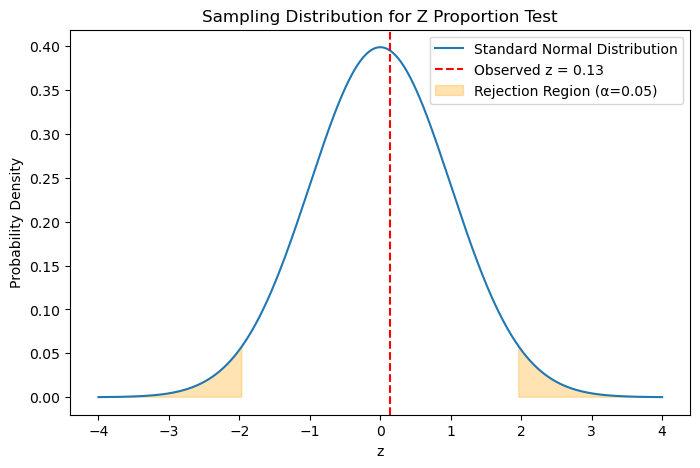

In [158]:
# Plot the standard normal distribution
x = np.linspace(-4, 4, 1000)
y = norm.pdf(x)

plt.figure(figsize=(8, 5))
plt.plot(x, y, label='Standard Normal Distribution')

# Mark the observed z-statistic
plt.axvline(z_stat, color='red', linestyle='--', label=f'Observed z = {z_stat:.2f}')

# (Optional) Shade the rejection region for two-sided test at alpha=0.05
alpha = 0.05
z_crit = norm.ppf(1 - alpha/2)
plt.fill_between(x, 0, y, where=(x <= -z_crit) | (x >= z_crit), color='orange', alpha=0.3, label='Rejection Region (α=0.05)')

plt.title('Sampling Distribution for Z Proportion Test')
plt.xlabel('z')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

A one-sample proportion test is used when you want to determine if the proportion of a single sample is significantly different from a known or hypothesized population proportion. For example, you might test whether the proportion of late shipments in your company differs from an industry standard. 12

A two-sample proportion test, on the other hand, is used to compare the proportions from two independent groups to see if there is a significant difference between them. For example, you might compare the proportion of late shipments between two different counties or time periods. 123

Key differences:

One-sample: Compares a sample proportion to a single known value. 12
Two-sample: Compares proportions between two independent samples. 123
Both tests use similar statistical methods (often a z-test), but the formulas and hypotheses differ based on whether you are comparing to a single value or between two groups

# Two-sample proportion tests

Does the amount paid for freight affect whether or not the shipment was late?

H0: late_expensive - late_reasonable = 0

HA: late_expensive - late_reasonable > 0

In [56]:
late = late_shipments[late_shipments['late'] == 'Yes']
late.head()

,id,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,late_delivery,late,product_group,sub_classification,...,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,freight_cost_groups,line_item_insurance_usd
0,36203.0,Nigeria,PMO - US,Direct Drop,EXW,Air,1.0,Yes,HRDT,HIV test,...,2996.0,266644.00,89.00,0.89,"Alere Medical Co., Ltd.",Yes,1426.0,33279.83,expensive,373.83
44,65081.0,Vietnam,PMO - US,Direct Drop,EXW,Air,1.0,Yes,ARV,Adult,...,14016.0,147168.00,10.50,0.35,Hetero Unit III Hyderabad IN,Yes,1955.0,6194.69,expensive,151.29
65,13926.0,South Africa,PMO - US,Direct Drop,DDP,Air,1.0,Yes,ARV,Adult,...,19992.0,156337.44,7.82,0.26,"Cipla, Goa, India",Yes,1378.0,3646.10,reasonable,337.06
68,25830.0,South Africa,PMO - US,Direct Drop,DDP,Air,1.0,Yes,ARV,Pediatric,...,11640.0,34920.00,3.00,0.01,"Aurobindo Unit III, India",Yes,4386.0,12917.30,expensive,75.29
78,47625.0,South Africa,PMO - US,Direct Drop,DDP,Air,1.0,Yes,ARV,Adult,...,54247.0,424211.54,7.82,0.26,"Cipla, Goa, India",Yes,3728.0,3646.13,reasonable,914.60


In [58]:
# quick check
late_shipments.groupby('freight_cost_groups')['late'].value_counts()

freight_cost_groups  late
expensive            No      489
                     Yes      42
reasonable           No      439
                     Yes      16
Name: count, dtype: int64

In [120]:
from statsmodels.stats.proportion import proportions_ztest

# Create an array of the "Yes" counts for each freight_cost_group
success_counts = np.array([42, 16])

# Create an array of the total number of rows in each freight_cost_group
n = np.array([489+42, 439+16])

# Run a z-test on the two proportions
stat, p_value = proportions_ztest(count=success_counts,nobs=n, 
alternative='larger' )


# Print the results
print("z-score:", stat, 'p_value:', p_value)

z-score: 2.922648567784529 p_value: 0.0017353400023595788


# Chi-square test of independence

Extending proportion testing to more than two groups..

Perhaps the incoterms affect whether or not the freight costs are expensive. Test these hypotheses with a significance level of 0.01.

H0: vendor_inco_term and freight_cost_group are independent.

HA: vendor_inco_term and freight_cost_group are associated.

In [112]:
# Proportion of freight_cost_group grouped by vendor_inco_term
props = late_shipments.groupby('vendor_inco_term')['freight_cost_groups'].value_counts(normalize=True)

In [114]:
props

vendor_inco_term  freight_cost_groups
CIP               reasonable             0.680000
                  expensive              0.320000
DDP               expensive              0.550000
                  reasonable             0.450000
DDU               reasonable             1.000000
EXW               expensive              0.583448
                  reasonable             0.416552
FCA               reasonable             0.663636
                  expensive              0.336364
Name: proportion, dtype: float64

In [124]:
wide_props = props.unstack()
wide_props

freight_cost_groups,expensive,reasonable
vendor_inco_term,,
CIP,0.320000,0.680000
DDP,0.550000,0.450000
DDU,NaN,1.000000
EXW,0.583448,0.416552
FCA,0.336364,0.663636


<Axes: xlabel='vendor_inco_term'>

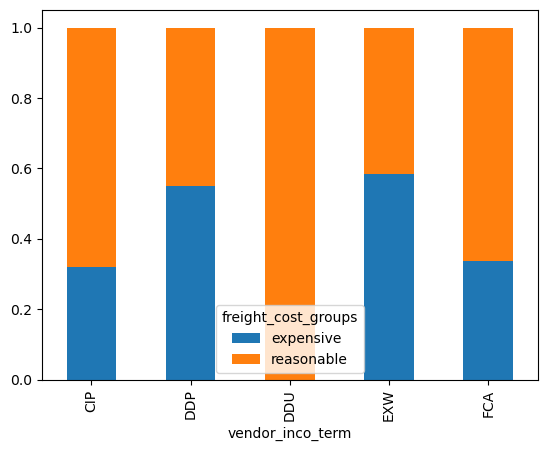

In [134]:
# Proportional stacked bar plot of freight_cost_group vs. vendor_inco_term
wide_props.plot(kind='bar', stacked=True)

In [150]:
# Performing a chi-square test of independence
import pingouin

expected, observed, stats = pingouin.chi2_independence(data=late_shipments, x='vendor_inco_term',y='freight_cost_groups'  )

/opt/anaconda3/lib/python3.12/site-packages/pingouin/contingency.py:151: UserWarning: Low count on observed frequencies.
  warnings.warn(f"Low count on {name} frequencies.")
/opt/anaconda3/lib/python3.12/site-packages/pingouin/contingency.py:151: UserWarning: Low count on expected frequencies.
  warnings.warn(f"Low count on {name} frequencies.")
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:7994: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:7994: RuntimeWarning: invalid value encountered in multiply
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:7991: RuntimeWarning: divide by zero encountered in divide
  terms = 2.0 * special.xlogy(f_exp, f_exp / f_obs)


In [152]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,34.805072,4.0,5.093922e-07,0.186561,0.999235
1,cressie-read,0.666667,34.845134,4.0,4.998337e-07,0.186669,0.999244
2,log-likelihood,0.000000,35.442911,4.0,3.767119e-07,0.188263,0.999361
3,freeman-tukey,-0.500000,NaN,4.0,NaN,NaN,NaN
4,mod-log-likelihood,-1.000000,inf,4.0,0.000000e+00,inf,NaN
5,neyman,-2.000000,NaN,4.0,NaN,NaN,NaN


In [154]:
stats[stats['test']  == 'pearson']

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.0,34.805072,4.0,5.093922e-07,0.186561,0.999235


# Assumptions in hypothesis testing

- **Randomness**: Samples are randolm subsets of larger populations
- **Independence** of observations: each row in the dataset is independent
- **Sample size** large enough that central limit theorem to applies

What does "independent rows" mean in practice?
Suppose you have a dataset where each row represents a shipment, and you are testing the proportion of late shipments. Independence means:

Whether one shipment is late or not does NOT affect whether another shipment is late or not.
There is no systematic relationship or connection between the outcomes of different shipments in your sample.
Why is this important?
Statistical tests (like the z-test for proportions) rely on the assumption of independence to correctly estimate variability and calculate p-values.
If the rows are not independent (for example, if shipments are grouped by the same customer, or if one late shipment causes others to be late), the test results may be invalid: p-values may be too small or too large, leading to incorrect conclusions.

Examples

**Independent rows**:

Each shipment is from a different customer, on a different day, and processed separately.

**Not independent**:

Multiple rows are shipments from the same order or customer (clustered data).
Shipments are processed in batches, and if one is late, the others in the batch are likely to be late too.
There is a time trend or process that links the outcomes (e.g., a system outage causes many shipments to be late at once).
